<a href="https://colab.research.google.com/github/kaispace30098/QB_item_quick_report/blob/main/Quickbooks_Item_Quick_Report_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

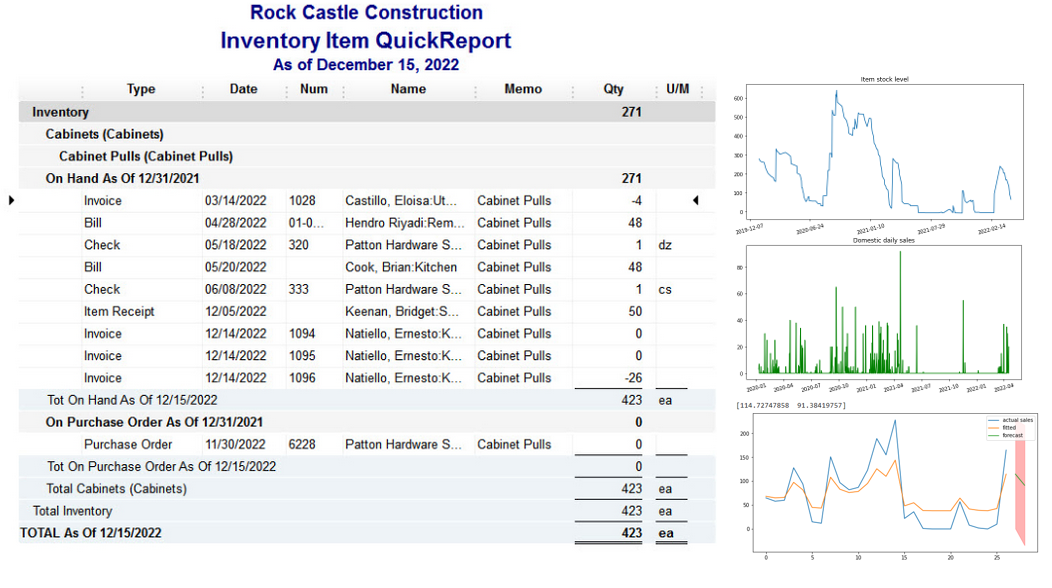

#**I.Data Preparation**

In [ ]:
#@title Step1. Environment setting: Install and Import some modules
import warnings
warnings.filterwarnings('ignore')
!pip install xlrd==2.0.1
!pip install sktime
!pip install pandasql
!pip install pmdarima
from pandasql import sqldf
from datetime import datetime
pysqldf = lambda q: sqldf(q, globals())
import pmdarima as pm
from sktime.forecasting.croston import Croston
import pandas as pd
import io
from google.colab import files
import numpy as np
def read_dir_file(case_f):  # case_f = 0 for uploading one File and case_f = 1 for uploading one Zipped Directory
        #uploaded = files.upload()    # to upload a Full Directory, please Zip it first (use WinZip)
        for fn in uploaded.keys():
            name = fn  #.encode('utf-8')
            #print('\nfile after encode', name)
            #name = io.BytesIO(uploaded[name])
        if case_f == 0:    # case of uploading 'One File only'
            print('\n file name: ', name)
            return name
        else:   # case of uploading a directory and its subdirectories and files
            zfile = zipfile.ZipFile(name, 'r')   # unzip the directory 
            zfile.extractall()
            for d in zfile.namelist():   # d = directory
                print('\n main directory name: ', d)
                return d

def date_range(start, end):
    delta = end - start  # as timedelta
    days = [start + timedelta(days=i) for i in range(delta.days + 1)]
    dayslist=[]
    for i in range(0,len(days)):
      dayslist.append(datetime.strptime(str(days[i])[:10],'%Y-%m-%d'))

    dfd=pd.DataFrame()
    dfd['date']=dayslist
    
    return dfd
def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
        match_value = return_array.loc[lookup_array == lookup_value]
        if match_value.empty:
            return 0 if if_not_found == '' else if_not_found

        else:
            return match_value.tolist()[0]

def Croston1(ts,extra_periods=1,alpha=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]# Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
 #@title Step2.Upload the list of invoice# from Direct import 
uploaded = files.upload()
fileName = read_dir_file(0)
dfdi=pd.read_csv(io.BytesIO(uploaded[fileName]))
for i in range(0,len(dfdi)):
  dfdi.Num.iloc[i]=str(dfdi.Num.iloc[i])




In [ ]:
#@title Step3.Upload the quickbook item's quick report
 #upload quick report
uploaded = files.upload()
fileName = read_dir_file(0)
df1=pd.read_csv(io.BytesIO(uploaded[fileName]))
inv0=df1.Qty.iloc[0]
Inv1=df1[df1['Unnamed: 0'].str.contains("Tot On Hand")==True]['Qty'].iloc[0]
#Clean the Table
df1=df1.drop(['Unnamed: 0'], axis=1)
df1=df1.dropna(subset=['Date'])
df1['Date'] = pd.to_datetime(df1.Date)
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')

df1['DI']=""
for i in range(0,len(df1)):
  df1['DI'].iloc[i]=xlookup(str(df1['Num'].iloc[i]), dfdi['Num'],dfdi['Num'])

#@title Retrieve data by condition

#Qty Group by date 
df2=df1[(df1.Type=='Bill')| (df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')]
#df2=df1[(df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')]


q = """SELECT Date, SUM(Qty)
       FROM df2 
       
       GROUP BY Date;"""
       

df2 = pysqldf(q)

df2['Cumsum']=df2['SUM(Qty)'].cumsum(axis = 0)+inv0


'====================================================================================='''

df3=df1[(df1.DI==0)][(df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')]

q = """SELECT Date, SUM(Qty)
       FROM df3
       
       GROUP BY Date;"""
df3 = pysqldf(q)
df3=df3[df3['SUM(Qty)']<=0]
df3['Cumsum']=df3['SUM(Qty)'].cumsum(axis = 0)


'====================================================================================='''

df4=df1[(df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')]

q = """SELECT Date, SUM(Qty)
       FROM df4
       
       GROUP BY Date;"""
df4 = pysqldf(q)
df4=df4[df4['SUM(Qty)']<=0]
df4['Cumsum']=df4['SUM(Qty)'].cumsum(axis = 0)



###*Conditions*
####0. All the domestic/international transactions are saved in a data frame (df1)
####1. All the transactions from Billing, Inventory Adjustment, and Invoices(df2)
####2. Domestic transactions from  Inventory Adjustment and Invoices(df3)
####3. All the transactions from Inventory Adjustment and Invoices(df4)

## #**II.Generate the Report Below**

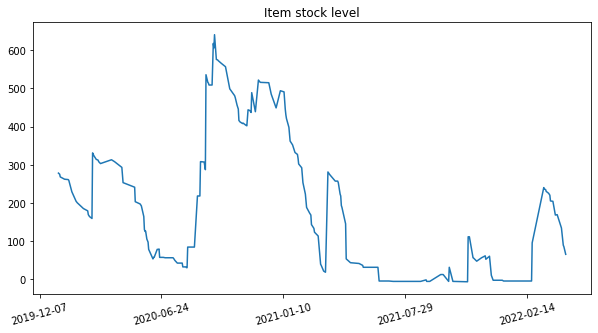

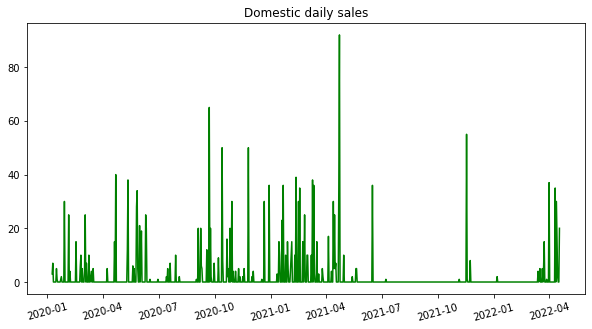

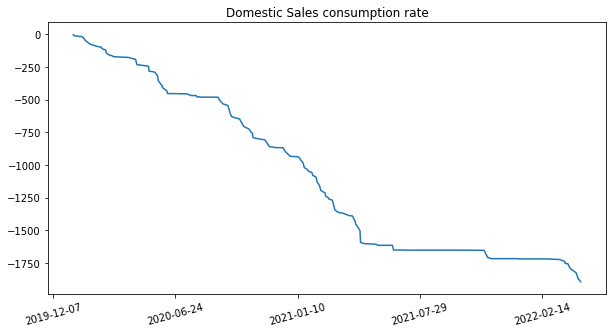

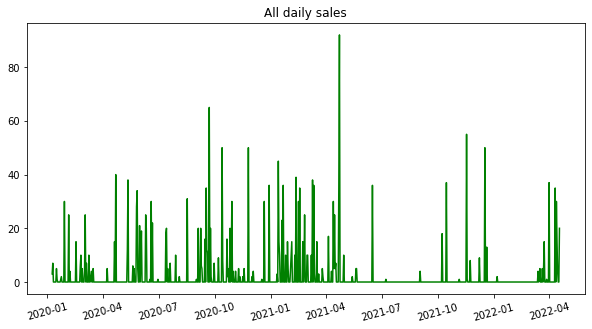

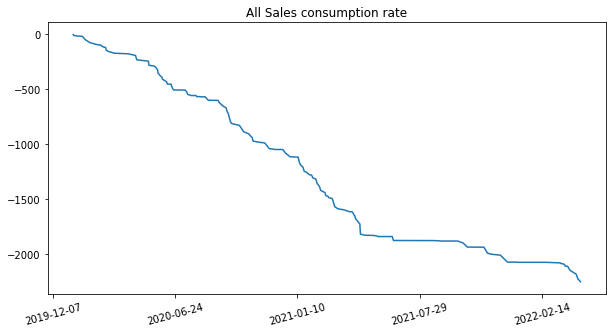

In [4]:
#@title 0.1) Plot the Stock Level and consumption Rate
import matplotlib 
import matplotlib.pyplot as plt 
from datetime import datetime
a = [datetime.strptime(d, '%Y-%m-%d') for d in df2.Date] 
  
b = df2['Cumsum']
x = matplotlib.dates.date2num(a) 
formatter = matplotlib.dates.DateFormatter('%Y-%m-%d') 
  
figure = plt.figure(figsize=(10,5)) 
axes = figure.add_subplot(1, 1, 1) 


axes.xaxis.set_major_formatter(formatter) 
plt.setp(axes.get_xticklabels(), rotation =15) 

axes.plot(x, b) 
plt.title("Item stock level")
plt.show()
'============================================================'
#Create a timeline and match each day's value 
from datetime import datetime, timedelta

#date_range function parameter setup
start_date = datetime(int(min(df3.Date)[:4])+0, int(min(df3.Date)[5:7])+0, int(min(df3.Date)[8:10])+0)
end_date = datetime(int(max(df3.Date)[:4])+0, int(max(df3.Date)[5:7])+0, int(max(df3.Date)[8:10])+0)
    
dfdate1=pd.DataFrame(date_range(start_date,end_date))

dfdate1['Sales']=""

for i in range(0,len(dfdate1)):
  dfdate1['Sales'].iloc[i]=(-1)*xlookup(str(dfdate1['date'].iloc[i])[:10], df3['Date'],df3['SUM(Qty)'])


figure = plt.figure(figsize=(10,5)) 
plt.plot(dfdate1['date'], dfdate1['Sales'],color='green')
plt.xticks(rotation=15)
plt.title('Domestic daily sales')
plt.show()
#ax.xaxis.set_ticklabels(dfdate.date)
'============================================================'

a = [datetime.strptime(d, '%Y-%m-%d') for d in df3.Date] 
  
b = df3['Cumsum']
x = matplotlib.dates.date2num(a) 
formatter = matplotlib.dates.DateFormatter('%Y-%m-%d') 
  
figure = plt.figure(figsize=(10,5)) 
axes = figure.add_subplot(1, 1, 1) 


axes.xaxis.set_major_formatter(formatter) 
plt.setp(axes.get_xticklabels(), rotation =15) 
  
axes.plot(x, b) 
plt.title("Domestic Sales consumption rate")
plt.show()

'==========================================================='
#Create a timeline and match each day's value ＤＡＴＡＦＲＡＭＥ　ＦＯＲ　ＡＮＡＬＹＳＩＳ 

#date_range function parameter setup
start_date = datetime(int(min(df4.Date)[:4])+0, int(min(df4.Date)[5:7])+0, int(min(df4.Date)[8:10])+0)
end_date = datetime(int(max(df4.Date)[:4])+0, int(max(df4.Date)[5:7])+0, int(max(df4.Date)[8:10])+0)
    
dfdate2=pd.DataFrame(date_range(start_date,end_date))

dfdate2['Sales']=""

for i in range(0,len(dfdate2)):
  dfdate2['Sales'].iloc[i]=(-1)*xlookup(str(dfdate2['date'].iloc[i])[:10], df4['Date'],df4['SUM(Qty)'])


figure = plt.figure(figsize=(10,5)) 
plt.plot(dfdate2['date'], dfdate2['Sales'],color='green')
plt.title('All daily sales')
plt.xticks(rotation=15)

#ax.xaxis.set_ticklabels(dfdate.date)
'================================================================'
a = [datetime.strptime(d, '%Y-%m-%d') for d in df4.Date] 
  
b = df4['Cumsum']
x = matplotlib.dates.date2num(a) 
formatter = matplotlib.dates.DateFormatter('%Y-%m-%d') 
  
figure = plt.figure(figsize=(10,5)) 
axes = figure.add_subplot(1, 1, 1) 


axes.xaxis.set_major_formatter(formatter) 
plt.setp(axes.get_xticklabels(), rotation =15) 
  
axes.plot(x, b) 
plt.title("All Sales consumption rate")
plt.show()

The Mean Square Error is:  7.96214780169947
The Mean Square Error is:  7.992328879252676
The Mean Square Error is:  8.065095061961506
The Mean Square Error is:  8.177346949157126
The Mean Square Error is:  8.330651040798095
the best RMSE is  7.96214780169947 and the alpha will be used is: 0.1


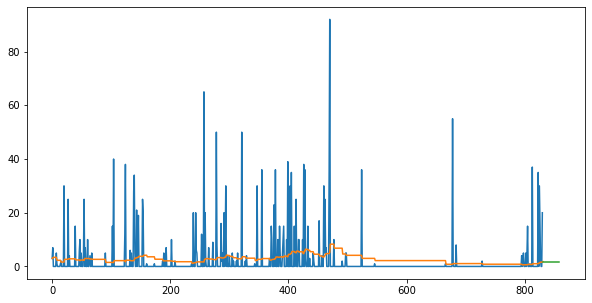

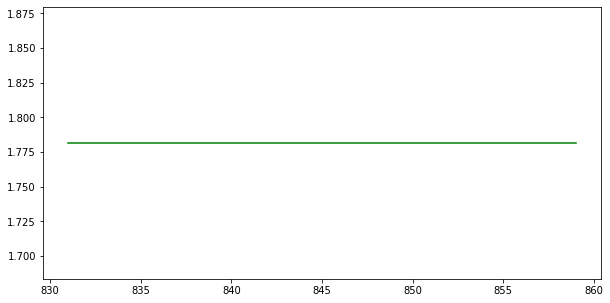

In [5]:
#@title 1.1) Croston's Prediction on Domestic Sales (df3)
plt.rcParams["figure.figsize"] = (10,5)
alpha_list=[0.1,0.2,0.3,0.4,0.5]
MinRMSE=99999
best_alpha=0
for i in range(0,5):
  alpha=alpha_list[i]
  new=Croston1(dfdate1["Sales"],alpha=alpha)
  summation = 0  #variable to store the summation of differences
  n = len(new)-1 #finding total number of items in list
  for i in range (0,n):  #looping through each element of the list
    difference = new.Demand.iloc[i] - new.Forecast.iloc[i]  #finding the difference between observed and predicted value
    squared_difference = difference*difference  #taking square of the differene 
    summation = summation + squared_difference  #taking a sum of all the differences
  MSE = summation/n  #dividing summation by total values to obtain average
  RMSE=MSE**(1/2)
  print ("The Mean Square Error is: " , RMSE)
  if RMSE<MinRMSE:
    best_alpha=alpha
    MinRMSE=RMSE
print("the best RMSE is ", MinRMSE, "and the alpha will be used is:", best_alpha)
#Configuration on header name and data type
df=dfdate1
df = dfdate1.rename(columns={0: 'date', 1: 'Sales'})
df.Sales.apply(pd.to_numeric)
df["Sales"] = pd.to_numeric(df["Sales"], downcast="float")
forecaster = Croston(smoothing=best_alpha)

forecaster.fit(df["Sales"])
fh1 = list(range(1, 30))

y_pred = forecaster.predict(fh=fh1)

new=Croston1(df["Sales"],alpha=best_alpha)
new.Demand.plot()
new.Forecast.plot()
y_pred.plot()
plt.show()
y_pred.plot(color='green')
plt.show()

In [6]:
#@title 1.2) Last Year Domestic Sales Projection on (Consumption within next two month, Re-order Qty for 3 months)
from datetime import datetime, timedelta
start=datetime.now().strftime('%Y-%m-%d')
pastdate = datetime.now() + timedelta(days=-365)
pastdate=pastdate.strftime('%Y-%m-%d')

leadtimesum=0
for i in range(dfdate1[dfdate1.date==pastdate].index[0],dfdate1[dfdate1.date==pastdate].index[0]+60):
  #print(dfdate['Sales'].iloc[i])
  leadtimesum+=dfdate1['Sales'].iloc[i]



reorder_qty=0
for i in range(dfdate1[dfdate1.date==pastdate].index[0]+60,dfdate1[dfdate1.date==pastdate].index[0]+150):
  #print(dfdate['Sales'].iloc[i])
  reorder_qty+=dfdate1['Sales'].iloc[i]

print("projection from last year:  \n(Consumption within next two month, Re-order Qty for 3 months) =(",leadtimesum, ",",reorder_qty,")")


"==================================================================="
df1['Date1'] = df1.Date.apply(lambda x: str(x).split(" ")[0])
df1['yearmon']=""
for i in range(0,len(df1)):
  df1['yearmon'].iloc[i]=df1['Date1'].iloc[i][:7]

table = pd.pivot_table(df1[(df1.DI==0)][(df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')], values='Qty', index=['Name'],columns='yearmon',

                    aggfunc=np.sum,fill_value=0,margins = True, margins_name='Total')
pd.set_option('display.max_columns', None)
display(table)

projection from last year:  
(Consumption within next two month, Re-order Qty for 3 months) =( 150.0 , 1.0 )


yearmon,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-11,2022-01,2022-02,2022-03,2022-04,Total
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
AIM WHOLESALE,0,0,0,0,0,0,0,0,-1,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.0
AMAZON - CAMPING,-13,-35,-11,-40,-60,0,0,0,0,0,0,-36,-36,0,-72,-108,0,-36,0,0,0,0,0,0,-5,-84,-536.0
ARROW DISTRIBUTING. INC,0,-5,0,0,0,-5,-10,0,0,-5,-5,0,0,-30,0,-10,0,0,0,0,0,0,0,0,-15,-5,-90.0
ATLAS TRAILER COACH,-15,0,0,0,0,0,0,0,0,0,0,0,0,-10,0,0,0,0,0,0,0,0,0,0,0,0,-25.0
AUSTIN FRENTZ ENTERPRISES,0,0,0,0,0,-1,-2,-2,-4,-2,-2,-4,0,0,-2,0,0,0,-1,0,0,-2,-2,0,-1,0,-25.0
BILL PLEMMONS INC.,0,0,-2,0,0,0,-2,0,0,0,0,0,-3,0,0,0,0,0,0,0,0,0,0,0,0,0,-7.0
CAMPING WORLD INC.,-10,-25,-30,0,-30,-30,0,0,-60,-60,-50,-30,-35,-70,0,-50,0,0,0,0,0,0,0,0,0,0,-480.0
COUMBS RV TRUCK,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0
FOLAND SALES INC,0,0,0,0,0,-4,0,0,0,0,0,0,-5,0,0,-2,-2,0,0,0,0,-8,0,0,0,0,-21.0


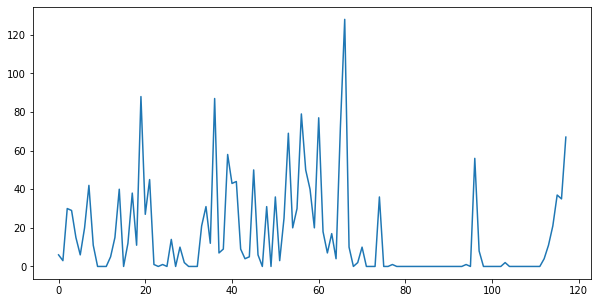

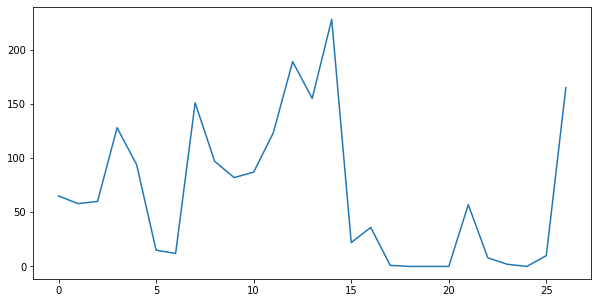

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=304.735, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=306.605, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=302.353, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=303.852, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=324.409, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=304.335, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=304.341, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=306.254, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=306.210, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.759 seconds
[114.72747858  91.38419757]
[ 68.29399891  65.04365534  65.97232493  97.5470911   81.75970802
  45.07725908  43.68425469 108.22679143  83.15271241  76.18769046
  78.50936444  95.22541712 125.8715137  110.08413061 143.98057077
  48.32760266  54.82828981  38.57657193  38.11223713  38.11223713
  3

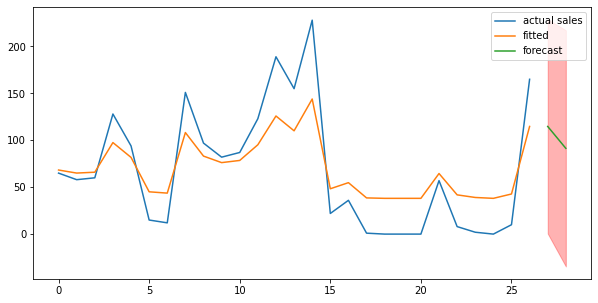

In [7]:
#@title 1.3) Converting daily data to weekly data and monthly data for ARIMA forecasting
plt.rcParams["figure.figsize"] = (10,5)
import math
day=[7,30]

for time in range(0,2):
  wdaysum=[]
  for i in range(len(dfdate1)-math.floor(len(dfdate1)/day[time])*day[time],len(dfdate1),day[time]):
    sum=0
    for j in range(0,day[time]):
       k=i+j    
       sum=sum+dfdate1.Sales.iloc[k]        
    wdaysum.append(sum)
  plt.plot(wdaysum)
  plt.show()
dfarima1=pd.DataFrame()
dfarima1['Sales']=wdaysum

# boolean series to index df rows
dftemp = pd.DataFrame({'A' : range(1, len(dfarima1)+3)})
dftemp.index[-2:]

model = pm.auto_arima(dfarima1['Sales'],
                      trace=True,
                      max_p=12, max_q=3, max_order=15,
                      suppress_warnings=True,
                      stepwise=True,
                      seasonal=12)

'========================================================================='
train_pred = model.predict_in_sample(start=1, end=len(dfarima1))
test_pred, confint = model.predict(n_periods=2, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot( dfarima1['Sales'], label='actual sales')
ax.plot( train_pred, label='fitted')
ax.plot(dftemp.index[-2:] ,test_pred, label='forecast')

ax.fill_between(dftemp.index[-2:] , \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)

ax.legend();

print(test_pred)
print(train_pred)


The Mean Square Error is:  8.631885027086888
The Mean Square Error is:  8.683326874826472
The Mean Square Error is:  8.769175873285604
The Mean Square Error is:  8.882880926570456
The Mean Square Error is:  9.029783948105033
the best RMSE is  8.631885027086888 and the alpha will be used is: 0.1


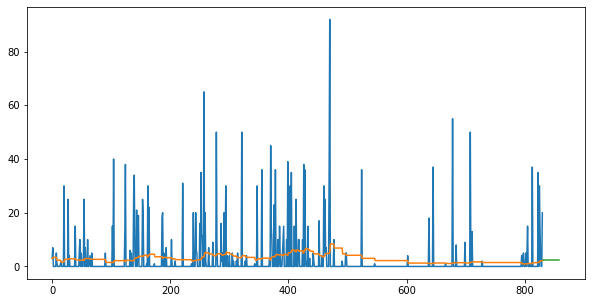

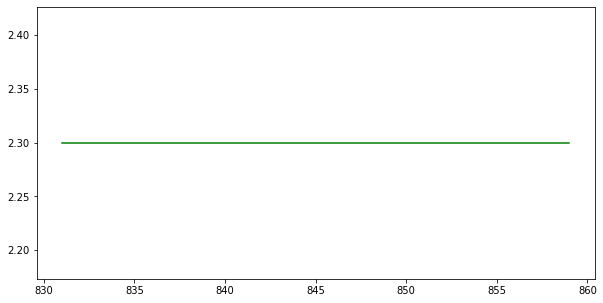

In [8]:
#@title 2.1) Croston's Prediction on all Sales (df4)
plt.rcParams["figure.figsize"] = (10,5)
alpha_list=[0.1,0.2,0.3,0.4,0.5]
MinRMSE=99999
best_alpha=0
for i in range(0,5):
  alpha=alpha_list[i]
  new=Croston1(dfdate2["Sales"],alpha=alpha)
  summation = 0  #variable to store the summation of differences
  n = len(new)-1 #finding total number of items in list
  for i in range (0,n):  #looping through each element of the list
    difference = new.Demand.iloc[i] - new.Forecast.iloc[i]  #finding the difference between observed and predicted value
    squared_difference = difference*difference  #taking square of the differene 
    summation = summation + squared_difference  #taking a sum of all the differences
  MSE = summation/n  #dividing summation by total values to obtain average
  RMSE=MSE**(1/2)
  print ("The Mean Square Error is: " , RMSE)
  if RMSE<MinRMSE:
    best_alpha=alpha
    MinRMSE=RMSE
print("the best RMSE is ", MinRMSE, "and the alpha will be used is:", best_alpha)
#Configuration on header name and data type
df=dfdate2
df = dfdate2.rename(columns={0: 'date', 1: 'Sales'})
df.Sales.apply(pd.to_numeric)
df["Sales"] = pd.to_numeric(df["Sales"], downcast="float")
forecaster = Croston(smoothing=best_alpha)

forecaster.fit(df["Sales"])
fh1 = list(range(1, 30))

y_pred = forecaster.predict(fh=fh1)

new=Croston1(df["Sales"],alpha=best_alpha)
new.Demand.plot()
new.Forecast.plot()
y_pred.plot()
plt.show()

y_pred.plot(color='green')
plt.show()

In [9]:
#@title 2.2) Last Year all Sales Projection on (Consumption within next two month, Re-order Qty for 3 months)
from datetime import datetime, timedelta
start=datetime.now().strftime('%Y-%m-%d')
pastdate = datetime.now() + timedelta(days=-365)
pastdate=pastdate.strftime('%Y-%m-%d')

leadtimesum=0
for i in range(dfdate2[dfdate2.date==pastdate].index[0],dfdate2[dfdate2.date==pastdate].index[0]+60):
  #print(dfdate2['Sales'].iloc[i])
  leadtimesum+=dfdate2['Sales'].iloc[i]



reorder_qty=0
for i in range(dfdate2[dfdate2.date==pastdate].index[0]+60,dfdate2[dfdate2.date==pastdate].index[0]+150):
  #print(dfdate2['Sales'].iloc[i])
  reorder_qty+=dfdate2['Sales'].iloc[i]
print("projection from last year:  \n(Consumption within next two month, Re-order Qty for 3 months) =","(",leadtimesum, ",",reorder_qty,")")


'======================================================================='
df1['Date1'] = df1.Date.apply(lambda x: str(x).split(" ")[0])
df1['yearmon']=""
for i in range(0,len(df1)):
  df1['yearmon'].iloc[i]=df1['Date1'].iloc[i][:7]

table = pd.pivot_table(df1[(df1.Type=='Invoice')|(df1.Type=='Inventory Adjust')], values='Qty', index=['Name'],columns='yearmon',

                    aggfunc=np.sum,fill_value=0)
pd.set_option('display.max_columns', None)
display(table)




projection from last year:  
(Consumption within next two month, Re-order Qty for 3 months) = ( 150.0 , 5.0 )


yearmon,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AIM WHOLESALE,0,0,0,0,0,0,0,0,-1,0,0,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AMAZON - CAMPING,-13,-35,-11,-40,-60,-52,-36,-31,-62,0,0,-36,-36,0,-72,-108,0,-36,0,0,-4,-55,0,-22,0,0,-5,-86
ARROW DISTRIBUTING. INC,0,-5,0,0,0,-5,-10,0,0,-5,-5,0,0,-30,0,-10,0,0,0,0,0,0,0,0,0,0,-15,-5
ATLAS TRAILER COACH,-15,0,0,0,0,0,0,0,0,0,0,0,-45,-10,0,0,0,0,0,0,0,0,0,-50,0,0,0,0
AUSTIN FRENTZ ENTERPRISES,0,0,0,0,0,-1,-2,-2,-4,-2,-2,-4,0,0,-2,0,0,0,-1,0,0,0,-2,0,-2,0,-1,0
BILL PLEMMONS INC.,0,0,-2,0,0,0,-2,0,0,0,0,0,-3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CAMPING WORLD INC.,-10,-25,-30,0,-30,-30,0,0,-60,-60,-50,-30,-35,-70,0,-50,0,0,0,0,0,0,0,0,0,0,0,0
COUMBS RV TRUCK,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FOLAND SALES INC,0,0,0,0,0,-4,0,0,0,0,0,0,-5,0,0,-2,-2,0,0,0,0,0,-8,0,0,0,0,0


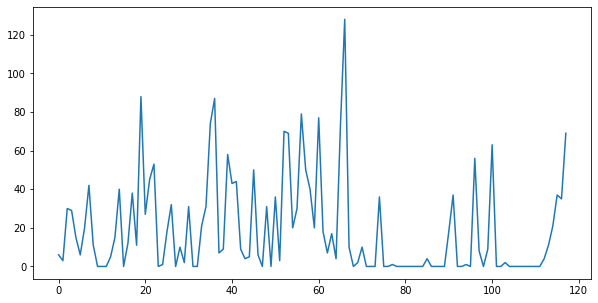

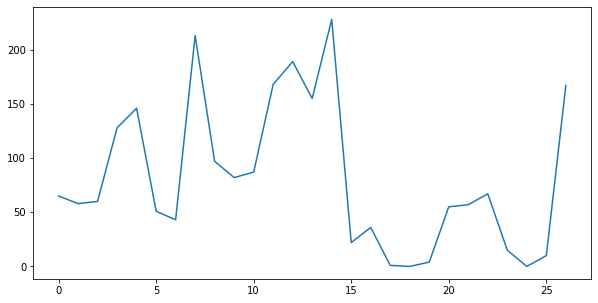

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=311.696, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=308.123, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=305.697, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=306.284, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=330.428, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=307.697, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=307.697, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=309.696, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=311.065, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.443 seconds
[116.20955435  96.16511399]


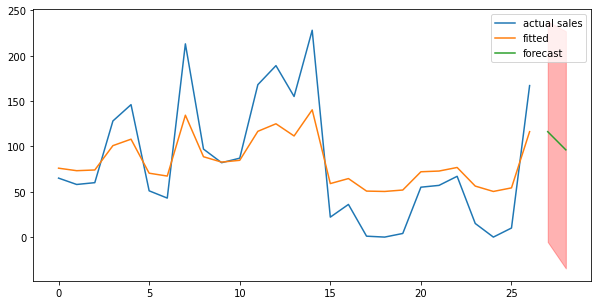

In [10]:
#@title 2.3) Converting daily data to weekly data and monthly data for ARIMA forecasting
plt.rcParams["figure.figsize"] = (10,5)
import math
day=[7,30]

for time in range(0,2):
  wdaysum=[]
  for i in range(len(dfdate2)-math.floor(len(dfdate2)/day[time])*day[time],len(dfdate2),day[time]):
    sum=0
    for j in range(0,day[time]):
       k=i+j    
       sum=sum+dfdate2.Sales.iloc[k]        
    wdaysum.append(sum)
  plt.plot(wdaysum)
  plt.show()

dfarima2=pd.DataFrame()
dfarima2['Sales']=wdaysum

# boolean series to index df rows
dftemp = pd.DataFrame({'A' : range(1, len(dfarima2)+3)})
dftemp.index[-2:]

model = pm.auto_arima(dfarima2['Sales'],
                      trace=True,
                      max_p=12, max_q=3, max_order=15,
                      suppress_warnings=True,
                      stepwise=True,
                      seasonal=12)

'========================================================================='
train_pred = model.predict_in_sample(start=1, end=len(dfarima2))
test_pred, confint = model.predict(n_periods=2, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot( dfarima2['Sales'], label='actual sales')
ax.plot( train_pred, label='fitted')
ax.plot(dftemp.index[-2:] ,test_pred, label='forecast')

ax.fill_between(dftemp.index[-2:] , \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)

ax.legend();

print(test_pred)
